In [1]:
import torch
from os import path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import h5py
import numpy as np
import wget
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import csv
from torchvision.utils import save_image


/home/sulaimon/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import os
import glob
from PIL import Image
import numpy as np
import torch


In [ ]:
## Download the images from Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

print("Path to dataset files:", path)

In [4]:
##Check if data path is correct
data_path = "/home/sulaimon/.cache/kagglehub/datasets/badasstechie/celebahq-resized-256x256/versions/1/celeba_hq_256"
image_files = glob.glob(os.path.join(data_path, '*.jpg'))
print(f'Found {len(image_files)} Images.')

Found 30000 Images.


In [5]:
def load_celebA_image(data_path):
    img = Image.open(data_path).convert('RGB')
    img_array = np.array(img, dtype=np.float32)/255.0
    return img_array

## Load all images into a numpy array
InputImages = np.array([load_celebA_image(f) for f in image_files ])
print("Dataset Shape:", InputImages.shape)

Dataset Shape: (30000, 256, 256, 3)


In [ ]:
def add_gaussian_noise(images, mean=0.1, stddev=0.1):
    noise = torch.normal( mean, stddev, images.shape)
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

InputImages = torch.tensor(InputImages, dtype=torch.float32).permute(0,3,1,2)
noisy_images = add_gaussian_noise(InputImages)


In [7]:
class CelebaADataset(Dataset):
    def __init__(self, noisy, clean):
        self.noisy = noisy
        self.clean = clean

    def __len__(self):
        return len(self.noisy)
    
    def __getitem__(self, idx):
        return self.noisy[idx], self.clean[idx]


##Splitting and Data Loader Creation
dataset = CelebaADataset(noisy_images, InputImages)

#Ensuring reproducibility
torch.manual_seed(42)
np.random.seed(42)

train_size = int(0.5 * len(dataset))
val_size = int(0.33 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)



##Verify the samples
def print_dataset_shapes(loader, name):
    data_iter = iter(loader)
    noisy_sample, clean_sample = next(data_iter)
    print(f"{name} set: Noisy shape: {noisy_sample.shape}, Clean shape: {clean_sample.shape}")


print_dataset_shapes(train_loader, "Train")
print_dataset_shapes(val_loader, "Validation")
print_dataset_shapes(test_loader, "Test")


print(f"Train set size: {len(train_set)}")
print(f"Val Set: {len(val_set)}")
print(f"Test Set: {len(test_set)}")

Train set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Validation set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Test set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Train set size: 15000
Val Set: 9900
Test Set: 5100


In [8]:
class UNet(nn.Module):
    def __init__(self, input_channels=3, Nc=64):
        super(UNet, self).__init__()

        # Contracting Path
        self.conv1 = self.conv_block(input_channels, Nc)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = self.conv_block(Nc, Nc * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = self.conv_block(Nc * 2, Nc * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = self.conv_block(Nc * 4, Nc * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = self.conv_block(Nc * 8, Nc * 16)

        # Expanding Path
        self.upconv6 = nn.ConvTranspose2d(Nc * 16, Nc * 8, kernel_size=2, stride=2)
        self.conv6 = self.conv_block(Nc * 16, Nc * 8)

        self.upconv7 = nn.ConvTranspose2d(Nc * 8, Nc * 4, kernel_size=2, stride=2)
        self.conv7 = self.conv_block(Nc * 8, Nc * 4)

        self.upconv8 = nn.ConvTranspose2d(Nc * 4, Nc * 2, kernel_size=2, stride=2)
        self.conv8 = self.conv_block(Nc * 4, Nc * 2)

        self.upconv9 = nn.ConvTranspose2d(Nc * 2, Nc, kernel_size=2, stride=2)
        self.conv9 = self.conv_block(Nc * 2, Nc)

        self.final_conv = nn.Conv2d(Nc, 3, kernel_size=1)
        self.final_merge_conv = nn.Conv2d(6, 3, kernel_size=1)  # Merging input and output

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

#Modification for printing intermediate outputs starts here

    def forward(self, x):
        outputs = {}


        # Contracting Path
        outputs["conv1"] = self.conv1(x)
        pool1 = self.pool1(outputs["conv1"])

        outputs["conv2"] = self.conv2(pool1)
        pool2 = self.pool2(outputs["conv2"])

        outputs["conv3"] = self.conv3(pool2)
        pool3 = self.pool3(outputs["conv3"])

        outputs["conv4"] = self.conv4(pool3)
        pool4 = self.pool4(outputs["conv4"])

        outputs["conv5"] = self.conv5(pool4)  # Bottleneck

        # Expanding Path
        up6 = self.upconv6(outputs["conv5"])
        merge6 = torch.cat((outputs["conv4"], up6), dim=1)
        outputs["conv6"] = self.conv6(merge6)

        up7 = self.upconv7(outputs["conv6"])
        merge7 = torch.cat((outputs["conv3"], up7), dim=1)
        outputs["conv7"] = self.conv7(merge7)

        up8 = self.upconv8(outputs["conv7"])
        merge8 = torch.cat((outputs["conv2"], up8), dim=1)
        outputs["conv8"] = self.conv8(merge8)

        up9 = self.upconv9(outputs["conv8"])
        merge9 = torch.cat((outputs["conv1"], up9), dim=1)
        outputs["conv9"] = self.conv9(merge9)

        outputs["final"] = self.final_conv(outputs["conv9"])

        return outputs  # Return all intermediate outputs

# Example usage
model = UNet(input_channels=3, Nc=64)

In [9]:
# print(model)

In [10]:
def psnr_metric(y_true, y_pred):
    mse = F.mse_loss(y_pred, y_true)
    return 10 * torch.log10(1 / mse)

def ssim_metric(y_true, y_pred):
    return torch.tensor(ssim(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), data_range=1.0))

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()


In [12]:

def train_model(model, train_loader, val_loader, epochs=25, save_path="best_model.pth"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    

    model.to(device)  # Move model to GPU if available
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.MSELoss()

    best_loss = float('inf')

    

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for noisy, clean in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(noisy)["final"]
            loss = loss_fn(outputs, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)  # Move data to GPU
                
                outputs = model(noisy)["final"]
                loss = loss_fn(outputs, clean)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save the model if validation loss improves
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with validation loss {best_loss:.4f}")

# Call the function
train_model(model, train_loader, val_loader)


Using device: cuda
Epoch 1, Train Loss: 0.0109, Val Loss: 0.0045
Model saved at epoch 1 with validation loss 0.0045
Epoch 2, Train Loss: 0.0050, Val Loss: 0.0044
Model saved at epoch 2 with validation loss 0.0044
Epoch 3, Train Loss: 0.0043, Val Loss: 0.0040
Model saved at epoch 3 with validation loss 0.0040
Epoch 4, Train Loss: 0.0039, Val Loss: 0.0056
Epoch 5, Train Loss: 0.0038, Val Loss: 0.0036
Model saved at epoch 5 with validation loss 0.0036
Epoch 6, Train Loss: 0.0036, Val Loss: 0.0041
Epoch 7, Train Loss: 0.0033, Val Loss: 0.0032
Model saved at epoch 7 with validation loss 0.0032
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0033
Epoch 9, Train Loss: 0.0030, Val Loss: 0.0026
Model saved at epoch 9 with validation loss 0.0026
Epoch 10, Train Loss: 0.0029, Val Loss: 0.0030
Epoch 11, Train Loss: 0.0028, Val Loss: 0.0031
Epoch 12, Train Loss: 0.0027, Val Loss: 0.0031
Epoch 13, Train Loss: 0.0026, Val Loss: 0.0026
Model saved at epoch 13 with validation loss 0.0026
Epoch 14, Train Loss:

In [13]:
def test_model(model, test_loader, device="cpu"):
    model.eval()
    model.to(device)
    total_psnr = 0
    total_ssim = 0
    num_samples = 0
    
    with torch.no_grad():
        for noisy, clean in test_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            outputs = model(noisy)["final"]
            
            for i in range(noisy.shape[0]):
                y_true = clean[i].permute(1, 2, 0).cpu().numpy()
                y_pred = outputs[i].permute(1, 2, 0).cpu().numpy()
                
                total_psnr += psnr(y_true, y_pred, data_range=1.0)
                total_ssim += ssim(y_true, y_pred, multichannel=True, data_range=1.0, win_size=3)

                num_samples += 1
    
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(num_samples)

# usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## Check out how to load weights
model.load_state_dict(torch.load('/home/sulaimon/EXPERIMENT/UNET with CelebA-HQ dataset/best_model.pth', weights_only=True))
##/home/sulaimon/EXPERIMENT/UNET with CelebA-HQ dataset/best_model.pth


test_model(model, test_loader, device)


Average PSNR: 26.54 dB
Average SSIM: 0.8808
5100


In [14]:
import os

import torch

def save_test_image_triplets_from_model(model, test_loader, device="cpu", output_dir="saved_unet_images"):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get one batch from the test set
    noisy_imgs, clean_imgs = next(iter(test_loader))
    noisy_imgs = noisy_imgs.to(device)
    clean_imgs = clean_imgs.to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        output_imgs = model(noisy_imgs)["final"]  # Assuming model returns dict with key "final"

    # Move to CPU for saving
    noisy_imgs = noisy_imgs.cpu()
    output_imgs = output_imgs.cpu()
    clean_imgs = clean_imgs.cpu()

    # Save the first 10 triplets
    for i in range(min(10, len(clean_imgs))):
        save_image(noisy_imgs[i], os.path.join(output_dir, f"img_{i+1:02d}_noisy.png"))
        save_image(output_imgs[i], os.path.join(output_dir, f"img_{i+1:02d}_denoised.png"))
        save_image(clean_imgs[i], os.path.join(output_dir, f"img_{i+1:02d}_clean.png"))

    print(f"Saved {min(10, len(clean_imgs)) * 3} images (triplets) to '{output_dir}'")


In [15]:
save_test_image_triplets_from_model(model, test_loader, device)


Saved 30 images (triplets) to 'saved_unet_images'


In [16]:
import csv

In [17]:
def save_metrics_csv_from_model(model, test_loader, device="cpu", csv_path="unet_metrics.csv"):

    model.eval()
    psnr_list = []
    ssim_list = []
    count = 0

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image Index", "PSNR", "SSIM"])

        with torch.no_grad():
            for noisy, clean in test_loader:
                noisy = noisy.to(device)
                clean = clean.to(device)

                outputs = model(noisy)["final"]

                clean_np = clean.squeeze(1).cpu().numpy()
                outputs_np = outputs.squeeze(1).cpu().numpy()

                for i in range(len(clean_np)):
                    psnr_val = psnr(clean_np[i], outputs_np[i], data_range=1.0)
                    ssim_val = ssim(clean_np[i], outputs_np[i], data_range=1.0, win_size=3)
                    psnr_list.append(psnr_val)
                    ssim_list.append(ssim_val)
                    writer.writerow([count + 1, psnr_val, ssim_val])
                    count += 1

        writer.writerow([])
        writer.writerow(["Average", np.mean(psnr_list), np.mean(ssim_list)])

    print(f"Saved PSNR/SSIM metrics for {count} images to '{csv_path}'")

In [18]:
save_metrics_csv_from_model(model, test_loader, device)


Saved PSNR/SSIM metrics for 5100 images to 'unet_metrics.csv'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0268514..1.0382745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0024852082..1.0232272].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0022729188..0.92047095].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017688598..0.97971517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04540228..1.0793227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.033759907..1.0102135].


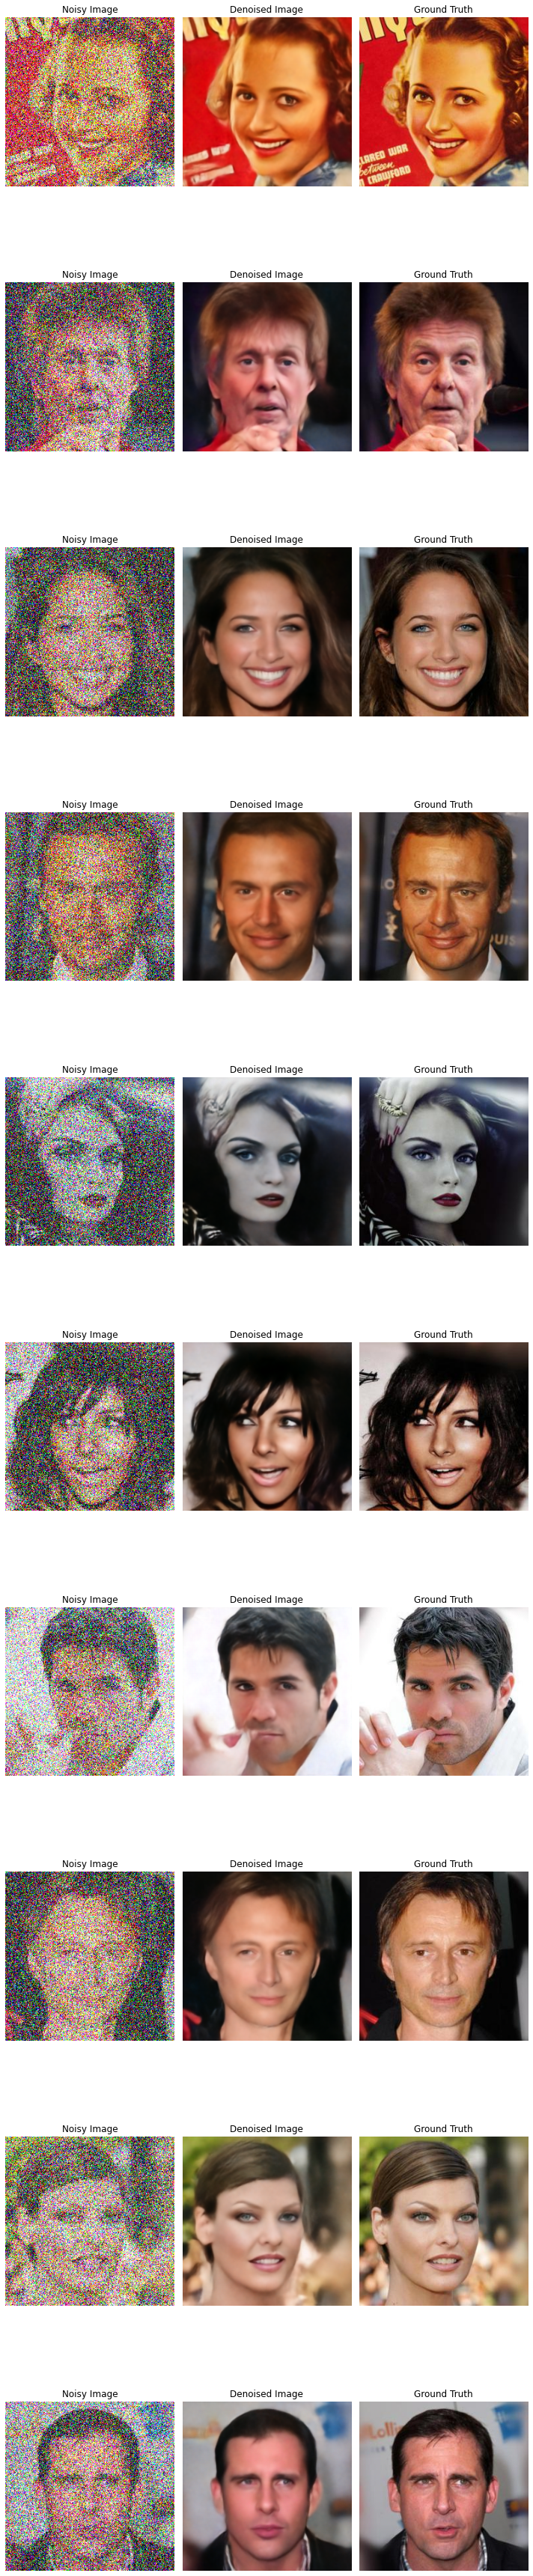

In [20]:
def visualize_results(model, test_loader, device, num_samples=10):
    model.eval()
    model.to(device)
    
    data_iter = iter(test_loader)
    noisy, clean = next(data_iter)
    noisy, clean = noisy.to(device), clean.to(device)
    
    with torch.no_grad():
        outputs = model(noisy)["final"]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))
    
    for i in range(num_samples):
        axes[i, 0].imshow(noisy[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title("Noisy Image")
        axes[i, 0].axis("off")
        axes[i, 1].imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title("Denoised Image")
        axes[i, 1].axis("off")
        axes[i, 2].imshow(clean[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

# usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_results(model, test_loader, device)
